In [97]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import chardet
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer

# Word Stemming
from nltk.stem.porter import PorterStemmer

# Word Lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Divisón estratificada
from sklearn.model_selection import train_test_split

In [2]:
# Descargas de nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# Crear una instancia del WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Crear una instancia del Porter Stemmer
stemmer = PorterStemmer()

# Crear una instancia del tokenizador
tokenizer = WhitespaceTokenizer()

# Lista de stopwords en ingles
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bcarr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [60]:
# Leer el archivo con la codificacion detectada
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df[['v1', 'v2']]

In [39]:
# Funcion para mapeo de POS a primer caracter
def get_wordnet_pos(word, tag):
    """Map POS tag to the first character lemmatize() accepts"""
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

### Análisis de datos exploratorio (EDA)

Cantidad de spam y ham

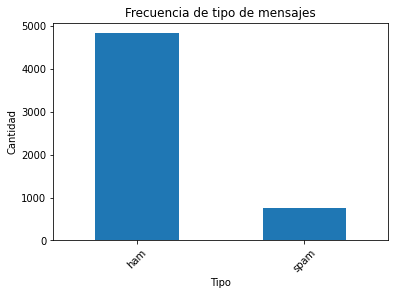

In [28]:
ax = df['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

### Limpieza de datos

Conversión a letras minúsculas

In [61]:
texts = df['v2'].tolist()
texts = [text.lower() for text in texts]

Tokenización de los textos

In [62]:
# texts = [tokenizer.tokenize(text) for text in texts]
texts = [word_tokenize(text) for text in texts]

Eliminando tokens con signos de puntuación

In [63]:
texts = [[token for token in text if not re.search(r'\W+', token)] for text in texts]

Eliminando tokens con números

In [64]:
texts = [[token for token in text if not re.search(r'[0-9]+', token)] for text in texts]

Eliminando stopwords

In [66]:
texts = [[token for token in text if token not in stop_words] for text in texts]

Lemmmatization

In [67]:
values = [nltk.pos_tag(text) for text in texts]
texts = [[lemmatizer.lemmatize(item[0], get_wordnet_pos(item[0], item[1])) for item in value] for value in values]

Stemming

In [68]:
texts = [[stemmer.stem(token) for token in text] for text in texts]

### Modelo

In [69]:
# Reemplazando la columna v2 por los valores obtenidos tras la limpieza
df['v2'] = texts

Conjunto de entrenamiento y prueba

In [98]:
train, test = train_test_split(df, test_size=0.20, stratify=df['v1'], random_state=42)

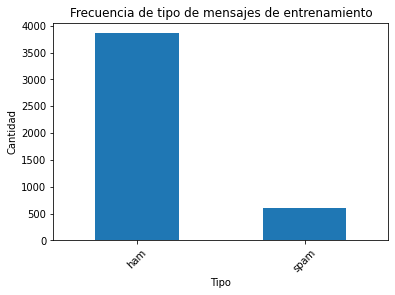

In [100]:
ax = train['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de entrenamiento')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

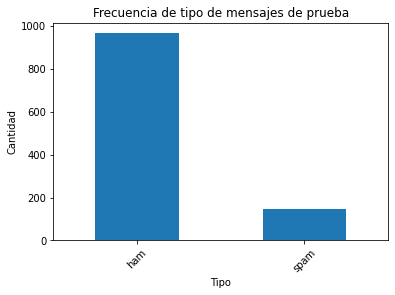

In [101]:
ax = test['v1'].value_counts().plot.bar()
plt.title('Frecuencia de tipo de mensajes de prueba')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor visualización
plt.show()

Construcción de los diccionarios

In [102]:
#Diccionarios para ham y spam
ham_words = {}
spam_words = {}

# Función para actualizar el diccionario de conteos
def update_word_count(word_list, word_dict):
    for word in word_list:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

# Iterar sobre el DataFrame y actualizar los diccionarios según la categoría
for _, row in train.iterrows():
    if row['v1'] == 'ham':
        update_word_count(row['v2'], ham_words)
    elif row['v1'] == 'spam':
        update_word_count(row['v2'], spam_words)


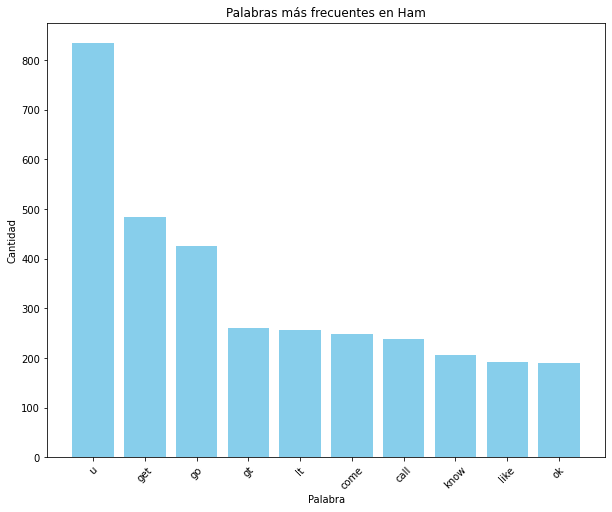

In [103]:
sorted_ham_words = sorted(ham_words.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sorted_ham_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Ham')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

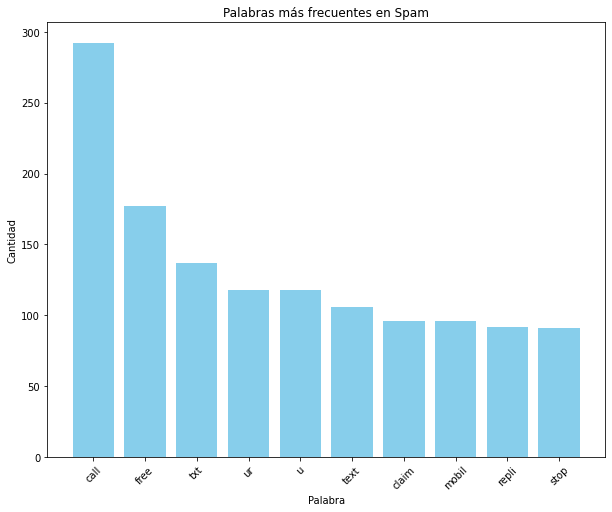

In [104]:
sorted_spam_words = sorted(spam_words.items(), key=lambda item: item[1], reverse=True)[:10]
words, counts = zip(*sorted_spam_words)  # Desempaquetar en listas separadas

# Crear la gráfica de barras
plt.figure(figsize=(10, 8))
plt.bar(words, counts, color='skyblue')
plt.title('Palabras más frecuentes en Spam')
plt.xlabel('Palabra')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

Probabilidades

In [133]:
# P(S), P(H)
cant_h, cant_s = train['v1'].value_counts().tolist()
cant_total = cant_h+cant_s

p_h = cant_h/cant_total
p_s = cant_s/cant_total

vocab_size = len(set(spam_words.keys()).union(set(ham_words.keys())))

total_words_in_spam = sum(spam_words.values())
total_words_in_ham = sum(ham_words.values())

additive_smoothing = 1

# Funcion P(S|W)
def p_s_w(word):
    # P(W|S) con suavizado de Laplace
    p_w_s = (spam_words.get(word, 0) + additive_smoothing) / (total_words_in_spam + additive_smoothing * vocab_size)

    # P(W|H) con suavizado de Laplace
    p_w_h = (ham_words.get(word, 0) + additive_smoothing) / (total_words_in_ham + additive_smoothing * vocab_size)

    # P(W|S) * P(S)
    numerator = p_w_s * p_s

    # [P(W|S) * P(S)] + [P(W|H) * P(H)]
    denominator = numerator + (p_w_h * p_h)

    return numerator / denominator if denominator != 0 else 0

In [135]:
def modelo(text):
    text = text.lower()
    tokens = word_tokenize(text)
    for token in tokens:
        print(p_s_w(token))
    

In [137]:
modelo('free hola')

0.59668562500021
0.29769801720105143


### Pruebas de rendimiento